In [19]:
import pandas as pd

In [20]:

df = pd.read_csv('iter.csv')


In [21]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...
9736,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9737,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [22]:
from tqdm import tqdm


In [23]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [24]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [25]:
import difflib


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [27]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 101088.82it/s]


[180, 177, 208, 233, 253, 267, 309, 295, 322, 342, 352, 386, 408, 427, 458, 468, 487, 523, 515, 545, 567, 561, 589, 602, 619, 642, 669, 638, 665, 707, 711, 728, 758, 796, 791, 801, 847, 848, 857, 872, 924, 917, 924, 958, 966, 960, 1004, 973, 1009, 1033, 1064, 1033, 1023, 1082, 1085, 1057, 1072, 1121, 1107, 1094, 1148, 1114, 1095, 1151, 1173, 1186, 1189, 1206, 1227, 1214, 1237, 1237, 1242, 1263, 1250, 1250, 1271, 1257, 1284, 1264, 1266, 1303, 1320, 1312, 1342, 1329, 1299, 1335, 1318, 1299, 1315, 1310, 1323, 1298, 1308, 1354, 1303, 1312, 1332, 1305, 1305, 1294, 1310, 1291, 1304, 1262, 1269, 1263, 1226, 903]


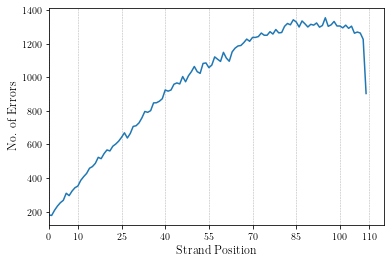

In [28]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [29]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:03<00:00, 3051.45it/s]


In [30]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> CC 6
 -> GG 6
AG ->  6
A -> T 7
GA ->  7
 -> GA 7
 -> CT 7
 -> AG 7
TC ->  8
 -> CA 8
TT ->  8
 -> GT 8
 -> AA 9
 -> TG 10
CT ->  10
T -> G 12
T -> A 12
 -> TT 12
 -> GC 13
CC -> T 13
G -> C 14
C -> G 14
G -> T 15
AA ->  18
C -> A 19
CC ->  29
 -> TC 38
GG ->  42
A -> G 78
T -> C 180
G -> A 195
A ->  200
C -> T 225
T ->  249
C ->  526
 -> A 532
G ->  536
 -> C 578
 -> G 606
 -> T 656


T -> C @ 38 6
 -> A @ 68 6
 -> A @ 15 6
 -> A @ 85 6
 -> A @ 8 6
T ->  @ 77 6
 -> A @ 19 6
 -> A @ 96 6
 -> A @ 23 6
 -> A @ 20 6
 -> A @ 22 6
C -> T @ 62 6
 -> T @ 75 6
G ->  @ 48 6
G ->  @ 50 6
G ->  @ 68 6
G ->  @ 76 6
G ->  @ 81 6
G ->  @ 84 6
 -> T @ 93 6
G ->  @ 91 6
G ->  @ 45 6
 -> T @ 89 6
 -> T @ 88 6
 -> T @ 78 6
 -> C @ 46 6
 -> T @ 73 6
 -> T @ 65 6
 -> T @ 49 6
 -> T @ 43 6
 -> T @ 39 6
G ->  @ 98 6
 -> T @ 25 6
G ->  @ 44 6
G ->  @ 30 6
C -> T @ 49 6
C -> T @ 16 6
C ->  @ 96 6
C ->  @ 91 6
C ->  @ 66 6
C ->  @ 58 6
C ->  @ 5 6
C ->  @ 48 6
G ->  @ 43 6
C ->  @ 33 6
C ->  @ 24 6
C ->  @ 109 6
C ->  @ 104 6
G ->  @ 1 6
G ->  @ 100 6
G ->  @ 107 6
G ->  @ 17 6
G ->  @ 2 6
C ->  @ 31 6
 -> T @ 17 6
C ->  @ 100 6
GG ->  @ 110 6
 -> C @ 72 6
 -> G @ 52 6
 -> C @ 75 6
 -> G @ 43 6
 -> G @ 42 6
 -> C @ 77 6
 -> G @ 33 6
 -> C @ 78 6
 -> C @ 80 6
 -> G @ 27 6
 -> C @ 93 6
 -> G @ 1 6
 -> G @ 102 6
 -> G @ 105 6
 -> G @ 107 6
 -> G @ 56 6
 -> C @ 70 6
 -> C @ 73 6
T ->  @ 109 6
 -

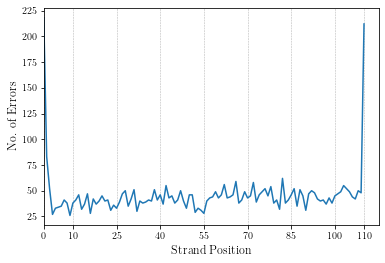

In [31]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.xlabel(r'Strand Position', fontsize=12)
plt.ylabel(r'No. of Errors', fontsize=12)
plt.grid(axis = 'x', linestyle='--', linewidth = 0.5)
plt.xlim(0, 115)
plt.xticks([0, 10, 25, 40, 55, 70, 85, 100, 110])
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [32]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [33]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [34]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[91, 7, 9, 4, 7, 4, 2, 3, 4, 3, 2, 8, 5, 2, 3, 7, 3, 6, 4, 2, 5, 4, 4, 5, 4, 6, 2, 4, 5, 3, 4, 11, 3, 5, 5, 4, 8, 4, 1, 6, 7, 4, 2, 6, 3, 2, 7, 4, 2, 6, 7, 7, 1, 4, 2, 2, 7, 3, 2, 5, 3, 3, 10, 3, 4, 6, 8, 5, 3, 1, 9, 11, 5, 6, 12, 6, 7, 1, 6, 3, 3, 3, 9, 5, 7, 8, 4, 4, 6, 6, 4, 5, 8, 6, 7, 4, 3, 2, 3, 5, 8, 10, 10, 15, 10, 8, 4, 2, 7, 4, 12]
[3, 6, 7, 0, 2, 1, 5, 2, 3, 2, 10, 4, 5, 3, 6, 5, 3, 4, 3, 10, 5, 7, 5, 1, 7, 3, 5, 6, 7, 2, 4, 8, 5, 6, 12, 2, 4, 5, 8, 5, 10, 2, 6, 6, 3, 3, 5, 1, 4, 5, 7, 5, 6, 3, 3, 3, 6, 4, 5, 4, 4, 4, 4, 4, 9, 5, 4, 7, 3, 8, 3, 2, 14, 4, 4, 6, 3, 4, 6, 4, 2, 4, 8, 9, 5, 3, 8, 4, 8, 9, 4, 7, 4, 8, 8, 3, 3, 5, 4, 4, 5, 5, 6, 9, 14, 6, 8, 6, 5, 8, 40]
[79, 9, 7, 4, 1, 3, 3, 5, 5, 3, 7, 5, 5, 4, 3, 4, 3, 4, 4, 2, 3, 3, 4, 3, 4, 3, 10, 3, 5, 4, 7, 7, 4, 4, 3, 4, 3, 5, 4, 3, 4, 3, 10, 4, 4, 5, 6, 4, 3, 1, 4, 3, 2, 3, 2, 6, 3, 8, 4, 5, 6, 4, 2, 3, 5, 5, 6, 3, 4, 3, 6, 9, 6, 6, 2, 6, 5, 6, 6, 3, 6, 3, 9, 4, 3, 3, 5, 4, 7, 3, 5, 5, 8, 6, 5, 4, 4, 5, 5, 3, 2, 3, 3, 4,

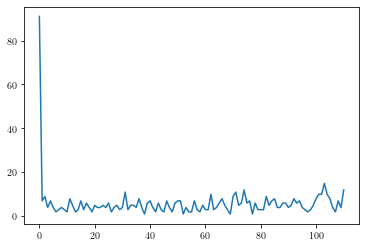

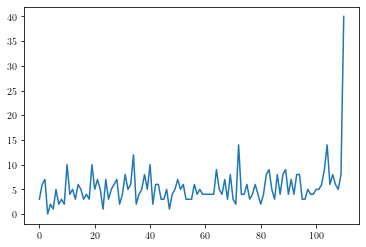

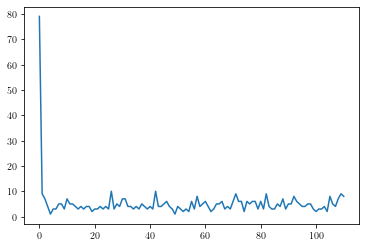

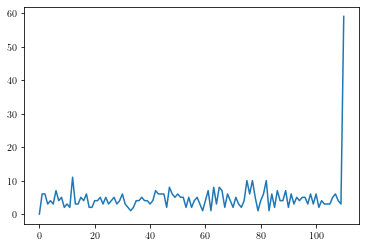

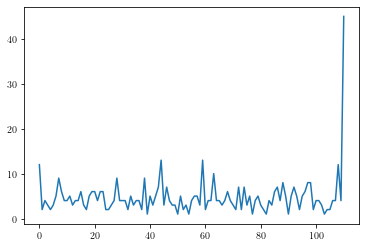

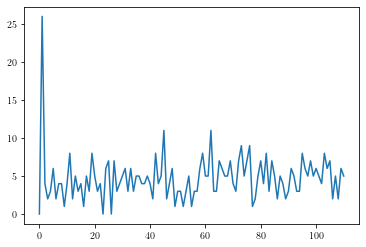

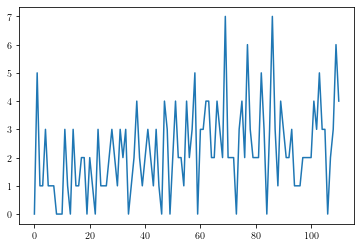

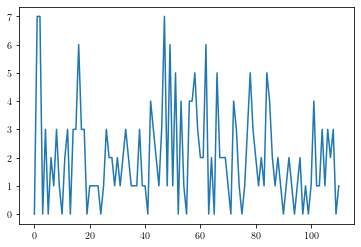

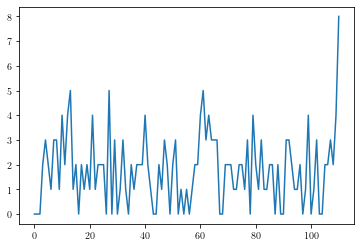

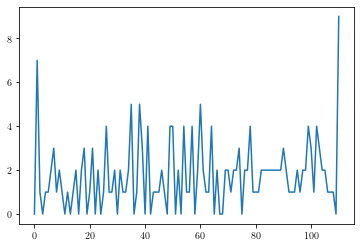

In [35]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [36]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)